In [7]:
import os
os.makedirs('model', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('src', exist_ok=True)

--- Step 1: Loading Data ---
Dataset loaded with 100000 rows and 13 columns.

--- Step 2: Splitting Data ---
Data split into training and testing sets.

--- Step 3: Defining and Training the Model Pipeline ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:45:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Step 4: Evaluating the Model on the Test Set ---
Accuracy: 0.7217

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.76      0.86      0.81     13474
     Churned       0.60      0.44      0.51      6526

    accuracy                           0.72     20000
   macro avg       0.68      0.65      0.66     20000
weighted avg       0.71      0.72      0.71     20000

--- Step 5: Generating Visualizations (will open in new windows) ---


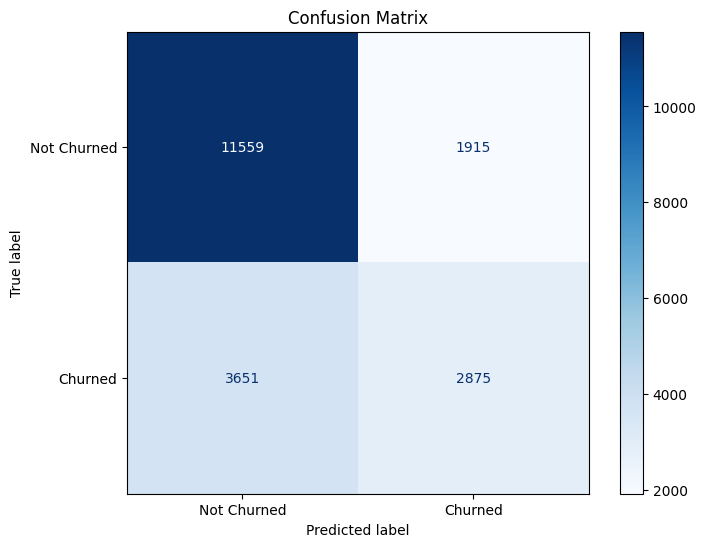

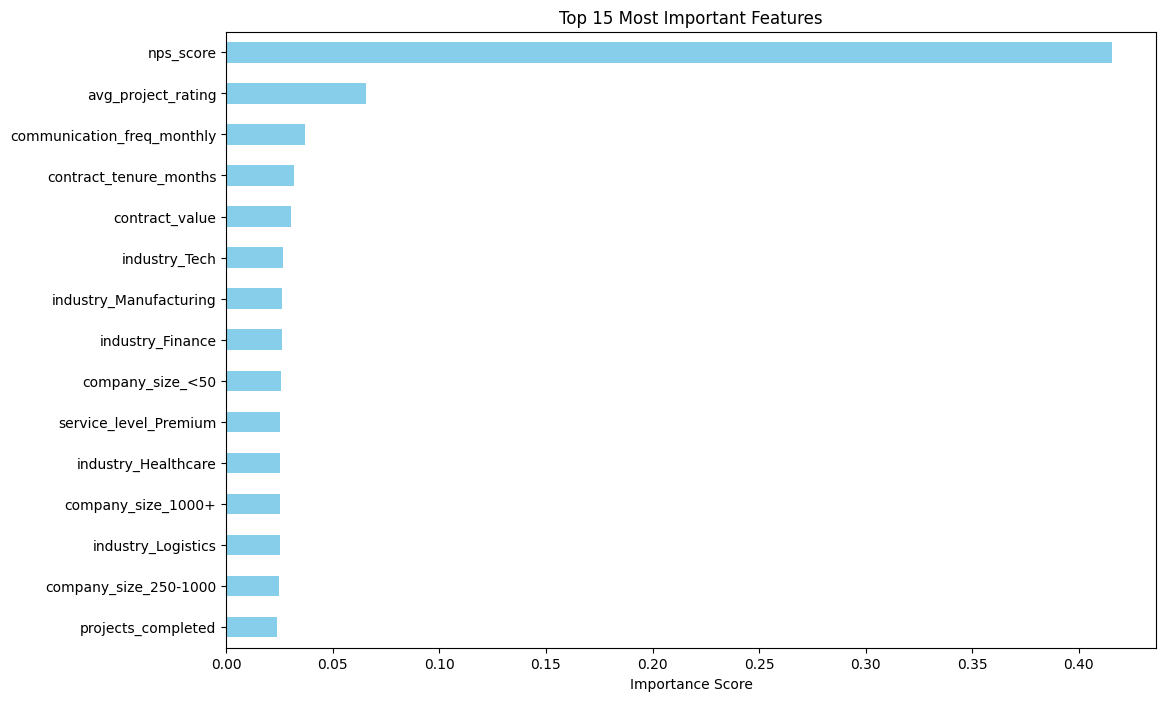


--- Step 6: Saving the Model ---
✅ Model successfully trained and saved to: 'models/churn_model_xgb.joblib'


In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- Setup: Add project's 'src' directory to the Python path ---
try:
    # This path adjustment assumes the script is run from the project root.
    # When running the .ipynb from the /notebooks dir, it needs to go up one level ('..').
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
    from src.data_preprocessing import get_preprocessing_pipeline
except (ImportError, IndexError, NameError):
     # A fallback for different execution environments
    try:
        from src.data_preprocessing import get_preprocessing_pipeline
    except ImportError:
        print("Error: Make sure you are running this script from the project's root directory")
        print("or that the 'src' folder is accessible.")
        sys.exit(1)


def explore_train_and_save():
    """
    Main function to run the full workflow: EDA, training, evaluation, and saving.
    """
    # --- Step 1: Load Data ---
    print("--- Step 1: Loading Data ---")
    DATA_PATH = 'data/consulting_churn_data.csv'
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.\n")
    except FileNotFoundError:
        print(f"Error: Data file not found at '{DATA_PATH}'. Please run the data generation script first.")
        return

    # --- Step 2: Data Splitting ---
    print("--- Step 2: Splitting Data ---")
    X = df.drop(['churn', 'client_id', 'company_name'], axis=1)
    y = df['churn']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Data split into training and testing sets.\n")

    # --- Step 3: Define and Train the Pipeline ---
    print("--- Step 3: Defining and Training the Model Pipeline ---")
    pipeline = Pipeline(steps=[
        ('preprocessor', get_preprocessing_pipeline()),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)
    print("Model training complete.\n")

    # --- Step 4: Evaluate the Model ---
    print("--- Step 4: Evaluating the Model on the Test Set ---")
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

    # --- Step 5: Visualize Results ---
    print("--- Step 5: Generating Visualizations (will open in new windows) ---")
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', display_labels=['Not Churned', 'Churned'])
    ax.set_title('Confusion Matrix')
    plt.show()

    # Feature Importance
    # (Code to extract and plot feature importance as before)
    preprocessor = pipeline.named_steps['preprocessor']
    classifier = pipeline.named_steps['classifier']
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(preprocessor.transformers_[0][2])
    numerical_cols = [col for col in X_train.columns if col not in preprocessor.transformers_[0][2]]
    all_feature_names = np.concatenate([ohe_feature_names, numerical_cols])
    feature_importances = pd.Series(classifier.feature_importances_, index=all_feature_names).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    feature_importances.head(15).sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance Score')
    plt.show()

    # --- Step 6: Save the Trained Model ---
    print("\n--- Step 6: Saving the Model ---")
    MODEL_DIR = 'models'
    MODEL_PATH = os.path.join(MODEL_DIR, 'churn_model_xgb.joblib')

    # Ensure the 'models' directory exists.
    os.makedirs(MODEL_DIR, exist_ok=True)

    # Save the entire trained pipeline to the file.
    #
    joblib.dump(pipeline, MODEL_PATH)

    print(f"✅ Model successfully trained and saved to: '{MODEL_PATH}'")


# --- Main execution block ---
if __name__ == "__main__":
    explore_train_and_save()